## Training a model with changedPages_last_5min feature

### Introduction
In this notebook, we'll train a taxifare prediction model but this time with an additional feature of changedPages_last_5min.

**Since the feature "changedPages_last_5min" is faked, the built model is not accurate.**

In [2]:
!pip install --user google-cloud-bigquery==1.25.0

In [3]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)
%matplotlib inline

2.3.1


In [4]:
PROJECT = 'buddie-270710' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'buddie_rec_data' # REPLACE WITH YOUR BUCKET NAME
REGION = 'europe-west4' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

In [5]:
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [6]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Load raw data

In [7]:
!ls -l ./data/rec-*

-rw-r--r--  1 rachelchen  staff   5236 Feb  6 22:14 ./data/rec-clientIds.csv
-rw-r--r--  1 rachelchen  staff   1993 Feb  6 22:14 ./data/rec-contentIds.csv
-rw-r--r--  1 rachelchen  staff     73 Feb  6 22:14 ./data/rec-orgIds.csv
-rw-r--r--  1 rachelchen  staff   4449 Feb  7 23:02 ./data/rec-test-000000000000.csv
-rw-r--r--  1 rachelchen  staff  42337 Feb  7 23:02 ./data/rec-train-000000000000.csv
-rw-r--r--  1 rachelchen  staff   5454 Feb  7 22:57 ./data/rec-valid-000000000000.csv


In [8]:
!head ./data/rec-*

==> ./data/rec-clientIds.csv <==
1608032019
1608035318
1608142561
1607941840
1608152467
1608313756
1608029665
1608270834
1609392225
1608023406

==> ./data/rec-contentIds.csv <==
/content/mix/2998
/content/mix/7661
/content/mix/3000
/content/video/2926
/content/mix/2849
/content/mix/2987
/content/e-learning/4818
/content/mix/7789
/content/mix/2995
/content/mix/7684

==> ./data/rec-orgIds.csv <==
educared-a
leeromgeving
buurtzorg-t
educared-t
skilly-educared
buurtzorg

==> ./data/rec-test-000000000000.csv <==
1395906622,1,content/mix/1508,educared-t,1
1395906622,1,content/mix/1508,educared-t,2
1306932743,1,content/mix/2844,leeromgeving,2
1306932743,1,content/mix/2844,leeromgeving,5
228208309,1,content/mix/2846,leeromgeving,9
228208309,1,content/mix/2846,leeromgeving,0
228208309,1,content/mix/2846,leeromgeving,9
325122874,2,content/mix/2846,leeromgeving,1
325122874,2,content/mix/2846,leeromgeving,4
1205691654,0,content/mix/2846,leeromgeving,3

==> ./data/rec-train-000000000000.csv <==
192

## Use tf.data to read the CSV files
These functions for reading data from the csv files are similar to what we used in the Introduction to Tensorflow module. Note that here we have an addtional feature traffic_last_5min.

In [9]:
!pip install tensorflow_recommenders

In [10]:
import shutil
import numpy as np
print(tf.__version__)

import tensorflow_recommenders as tfrs

2.3.1


In [11]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'clientId,timeOnPage,contentId,organization,changedPages'.split(',')
LABEL_COLUMN = 'timeOnPage'

DEFAULTS = [['0.0'], [0.0], ['null'], ['null'],[0.0]]

In [12]:
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data #only remains clientId, contentId, organization in features
    return features, label  # features, label

In [13]:
from typing import Dict, Text

def load_dataset(pattern, batch_size=1, mode='eval'):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: 'train' | 'eval' to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    print("mode = {}".format(mode))
    
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        header=False)

    dataset = dataset.map(map_func=features_and_labels)  # features, label

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=10).repeat()
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [14]:
from datetime import datetime

TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 1000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 1000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('./data/rec-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('./data/rec-val*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

mode = train
mode = eval


## build simple model 

In [138]:
"""## UserModel & ArticleModel"""
class UserModel(tf.keras.Model):
    def __init__(self,uniq_clients, uniq_org):
        super().__init__()
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=uniq_clients, mask_token=None),
            tf.keras.layers.Embedding(len(uniq_clients) + 1, 32),
        ])
        self.org_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=uniq_org, mask_token=None),
            tf.keras.layers.Embedding(len(uniq_org) + 1, 32),
        ])
        self.normalized_changedPages = tf.keras.layers.experimental.preprocessing.Normalization()
   
    def call(self, features):
        return tf.concat([
            self.user_embedding(features["clientId"]),
            self.org_embedding(features["organization"]),
            self.normalized_changedPages(features["changedPages"])
        ], axis=1)
    
    
class ArticleModel(tf.keras.Model):
    def __init__(self,uniq_content):
        super().__init__()
        max_tokens = 10_000
        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=uniq_content, mask_token=None),
          tf.keras.layers.Embedding(len(uniq_content) + 1, 32)
        ])
        self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)
        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])
        self.title_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(uniq_content))

    def call(self, contentIds):
        return tf.concat([
            self.title_embedding(contentIds),
            self.title_text_embedding(contentIds)
        ], axis=1)


class ArticlelensModel(tfrs.models.Model):
    def __init__(self, uniq_content, uniq_clients, uniq_org) -> None:

        super().__init__()    
        self.query_model = tf.keras.Sequential([
          UserModel(uniq_clients, uniq_org),
          tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
          ArticleModel(uniq_content),
          tf.keras.layers.Dense(32)
        ])
        articles = tf.data.Dataset.from_tensor_slices(uniq_content)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=articles.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, data, training=False):
        features = data[0]
        user_embeddings = self.query_model({
            "clientId": features["clientId"],
            "organization": features["organization"],
            "changedPages": features["changedPages"]
        })
        article_embeddings = self.candidate_model(features["contentId"])

        return self.task(user_embeddings, article_embeddings)


In [139]:
UNIQ_CLIENTS = [str(x) for x in pd.read_csv('./data/rec-clientIds.csv', header=None)[0].values]
UNIQ_CONTENT = pd.read_csv('./data/rec-contentIds.csv', header=None)[0].values
articles = tf.data.Dataset.from_tensor_slices(UNIQ_CONTENT)
UNIQ_ORG = pd.read_csv('./data/rec-orgIds.csv', header=None)[0].values

In [140]:
model = ArticlelensModel(uniq_content = UNIQ_CONTENT,
                         uniq_clients = UNIQ_CLIENTS,
                         uniq_org = UNIQ_ORG)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [141]:
# keras_model.summary()

In [142]:
LOGDIR = "./taxi_trained"

history = model.fit(trainds, validation_data=evalds, validation_steps=1,
                    epochs=20,
                    steps_per_epoch=NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS),
                    callbacks=[tf.keras.callbacks.TensorBoard(LOGDIR)])

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/31 [..............................] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.2188 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 111.1894 - regularization_loss: 0.0000e+00 - total_loss: 111.1894WARNING:tensorflow:From /Applications/condaSoftware/anaconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
31/31 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0171 - factorized_top_k/top_5_categorical_accuracy: 0.103

Epoch 8/20
31/31 [==============================] - 2s 57ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0040 - factorized_top_k/top_5_categorical_accuracy: 0.0645 - factorized_top_k/top_10_categorical_accuracy: 0.1562 - factorized_top_k/top_50_categorical_accuracy: 0.9980 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 104.2318 - regularization_loss: 0.0000e+00 - total_loss: 104.2318 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0420 - val_factorized_top_k/top_10_categorical_accuracy: 0.2220 - val_factorized_top_k/top_50_categorical_accuracy: 0.8940 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 6783.5093 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6783.5093
Epoch 9/20
31/31 [==============================] - 2s 58ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0121 - factorized_top_k/top_5_categorical_accuracy: 0.0776 - factorized_top_k/top_10_ca

31/31 [==============================] - 2s 57ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0111 - factorized_top_k/top_5_categorical_accuracy: 0.1149 - factorized_top_k/top_10_categorical_accuracy: 0.2571 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 101.4854 - regularization_loss: 0.0000e+00 - total_loss: 101.4854 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0560 - val_factorized_top_k/top_10_categorical_accuracy: 0.0560 - val_factorized_top_k/top_50_categorical_accuracy: 0.9020 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 6873.3887 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6873.3887
Epoch 19/20
31/31 [==============================] - 2s 56ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0101 - factorized_top_k/top_5_categorical_accuracy: 0.0796 - factorized_top_k/top_10_categorical_

In [146]:
history.history

{'factorized_top_k/top_1_categorical_accuracy': [0.01713709719479084,
  0.00705645140260458,
  0.006048386916518211,
  0.01411290280520916,
  0.010080644860863686,
  0.010080644860863686,
  0.01411290280520916,
  0.004032257944345474,
  0.012096773833036423,
  0.01713709719479084,
  0.011088709346950054,
  0.012096773833036423,
  0.006048386916518211,
  0.01411290280520916,
  0.008064515888690948,
  0.013104838319122791,
  0.009072580374777317,
  0.011088709346950054,
  0.010080644860863686,
  0.013104838319122791],
 'factorized_top_k/top_5_categorical_accuracy': [0.10383064299821854,
  0.055443547666072845,
  0.058467742055654526,
  0.06854838877916336,
  0.07963709533214569,
  0.05443548411130905,
  0.061491936445236206,
  0.06451612710952759,
  0.0776209682226181,
  0.08266129344701767,
  0.07157257944345474,
  0.07560484111309052,
  0.06754032522439957,
  0.06854838877916336,
  0.08165322244167328,
  0.07963709533214569,
  0.0776209682226181,
  0.11491935700178146,
  0.079637095332

<AxesSubplot:>

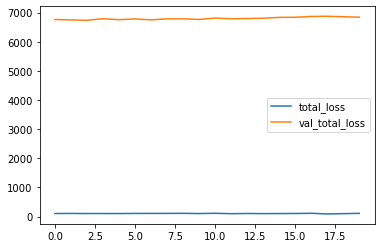

In [147]:
RMSE_COLS = ['total_loss', 'val_total_loss']

pd.DataFrame(history.history)[RMSE_COLS].plot()

In [152]:
metrics = model.evaluate(evalds, return_dict=True)
metrics

1/1 [==============================] - 0s 32ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0080 - factorized_top_k/top_5_categorical_accuracy: 0.0490 - factorized_top_k/top_10_categorical_accuracy: 0.0650 - factorized_top_k/top_50_categorical_accuracy: 0.9010 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 6846.0674 - regularization_loss: 0.0000e+00 - total_loss: 6846.0674


{'factorized_top_k/top_1_categorical_accuracy': 0.00800000037997961,
 'factorized_top_k/top_5_categorical_accuracy': 0.04899999871850014,
 'factorized_top_k/top_10_categorical_accuracy': 0.06499999761581421,
 'factorized_top_k/top_50_categorical_accuracy': 0.9010000228881836,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 6846.0673828125,
 'regularization_loss': 0,
 'total_loss': 6846.0673828125}

## Explore and deploy model

In [154]:
index = tfrs.layers.factorized_top_k.BruteForce(keras_model.query_model)
index.index(articles.batch(100).map(keras_model.candidate_model), articles)

# Get some recommendations.
socres, titles = index({
                "clientId": np.array(["160145"]),
                "organization": np.array(["leeromgeving"]),
                "changedPages":np.array([5])})


print(f"Top 3 recommendations for user 160145 under leeromgeving environment: {titles[0, :3]}")

Consider rewriting this model with the Functional API.
Top 3 recommendations for user 160145 under leeromgeving environment: [b'/content/video/4813' b'/content/mix/7546' b'/content/video/1068']


In [165]:
import datetime
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR,
                           datetime.datetime.now().strftime("%Y%m%d%H%M%S"))

index.save(EXPORT_PATH)
print('Model exported to: {}'.format(EXPORT_PATH))

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Assets written to: ./export/savedmodel/20210208182959/assets
Model exported to: ./export/savedmodel/20210208182959


In [181]:
EXPORT_PATH = EXPORT_PATH

In [183]:
%%bash
PROJECT=${PROJECT}
BUCKET=${BUCKET}
REGION=${REGION}
MODEL_NAME=tfrs_rec
VERSION_NAME=streaming_test

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow \
       --python-version=3.7 \
       --runtime-version=2.3 \
       --origin=${EXPORT_PATH} \
       --staging-bucket=gs://$BUCKET

tfrs_rec already exists
Creating tfrs_rec:streaming_test


Using endpoint [https://europe-west4-ml.googleapis.com/]
Using endpoint [https://europe-west4-ml.googleapis.com/]
Using endpoint [https://europe-west4-ml.googleapis.com/]
